In [1]:
import numpy as np
import sys
sys.path.append('../../')
import do_mpc
from casadi import *
import matplotlib.pyplot as plt
N_ref = 600
N = 50
x_ref = np.linspace(0,20,N_ref + N + 1) #From Path Planning
y_ref = 0.15*np.sin(x_ref*x_ref) #From Path Planning
J = 380
La = 1.3
Lb = 1.3
m = 500
Cy = 0.01
t_s = 0.01 #sample time

In [2]:
def mpc_model():
    # Obtain an instance of the do-mpc model class
    # and select time discretization:
    model_type = 'continuous' # either 'discrete' or 'continuous'
    model = do_mpc.model.Model(model_type)

    # Introduce new states, inputs and other variables to the model, e.g.:
    xc=model.set_variable(var_type='_x',var_name='xc',shape=(1,1))
    yc=model.set_variable(var_type='_x',var_name='yc',shape=(1,1))
    v=model.set_variable(var_type='_x',var_name='v',shape=(1,1))
    theta=model.set_variable(var_type='_x',var_name='theta',shape=(1,1))
    phi=model.set_variable(var_type='_x',var_name='phi',shape=(1,1))
    delta=model.set_variable(var_type='_x',var_name='delta',shape=(1,1))
    a_s=model.set_variable(var_type='_x',var_name='a_s',shape=(1,1))
    w_s=model.set_variable(var_type='_x',var_name='w_s',shape=(1,1))
    
    #time varying setpoint for path following
    target_x = model.set_variable(var_type = '_tvp', var_name = 'target_x', shape = (1,1))
    target_y = model.set_variable(var_type = '_tvp', var_name = 'target_y', shape = (1,1))
    
    #control inputs
    a=model.set_variable(var_type='_u',var_name='a',shape=(1,1))
    w=model.set_variable(var_type='_u',var_name='w',shape=(1,1))

    # Set right-hand-side of ODE for all introduced states (_x).
    # Names are inherited from the state definition.
    
    Fyf=Cy*(delta-(La*phi)/v)
    Fyr=(Cy*Lb*phi)/v
    
    equations=vertcat(v*np.cos(theta), 
              v*np.sin(theta),
              a_s* np.cos(delta)-(2.0/m)*Fyf*np.sin(delta),
              phi,
              (1.0/J)*(La*(m*a*np.sin(delta)+2*Fyf*np.cos(delta))-2*Lb*Fyr),
              w,
              (1/t_s)*(a-a_s),
              (1/t_s)*(w-w_s))
    
    
    
    model.set_rhs('xc',equations[0])
    model.set_rhs('yc',equations[1])
    model.set_rhs('v',equations[2])
    model.set_rhs('theta',equations[3])
    model.set_rhs('phi',equations[4])
    model.set_rhs('delta',equations[5])
    model.set_rhs('a_s',equations[6])
    model.set_rhs('w_s',equations[7])

    # Setup model:
    model.setup()

    return model

In [3]:
def controller(model, x_ref,y_ref):
    # Obtain an instance of the do-mpc MPC class
    # and initiate it with the model:
    mpc = do_mpc.controller.MPC(model)

    # Set parameters:
    setup_mpc = {
        'n_horizon': N,
        't_step': t_s,
        'n_robust': 0,
        'open_loop':0,
        'state_discretization': 'collocation',
        'collocation_type': 'radau',
        'collocation_deg': 2,
        'collocation_ni': 2,
        'store_full_solution': True,
    }
    mpc.set_param(**setup_mpc)
    
    #Configuring the time varying behaviour of the setpoints
    
    tvp_temp = mpc.get_tvp_template()
    def tvp_fun(t_now):
        for k in range(N+1):
                tvp_temp['_tvp',k,'target_x'] = x_ref[int(t_now//t_s) + k]
                tvp_temp['_tvp',k,'target_y'] = y_ref[int(t_now//t_s) + k]
        return tvp_temp
    
    mpc.set_tvp_fun(tvp_fun)
    
    

    # Configure objective function:
#     cost = ((model.x['xc'] - model.tvp['target_x'])/(model.tvp['target_x']+1e-9))**2 + ((model.x['yc'] - model.tvp['target_y'])/(model.tvp['target_y']+1e8) )**2
    cost = ((model.x['xc'] - model.tvp['target_x']))**2 + ((model.x['yc'] - model.tvp['target_y']))**2
    
    mterm = cost # terminal cost
    lterm = cost # stage cost

    mpc.set_objective(mterm = mterm, lterm = lterm)
    mpc.set_rterm(a = 0.00001)
    mpc.set_rterm(w = 0.00001) # Scaling for quad. cost.

    # State and input bounds:
#     mpc.bounds['lower','_x','xc'] = x_0[0]-1e-4
#     mpc.bounds['lower','_x','yc'] = y_lower
    mpc.bounds['lower','_x','v'] = 0 #max reverse speed in m/s
    mpc.bounds['lower','_x','theta'] = -50
    mpc.bounds['lower','_x','phi'] = -50
    mpc.bounds['lower','_x','delta'] = -np.pi/6
#     mpc.bounds['upper','_x','xc'] = target_x+0.1
#     mpc.bounds['upper','_x','yc'] = y_upper
    mpc.bounds['upper','_x','v'] = 20 #max forward speed in m/s
    mpc.bounds['upper','_x','theta'] = 50
    mpc.bounds['upper','_x','phi'] = 50
    mpc.bounds['upper','_x','delta'] = np.pi/6
    mpc.bounds['lower','_u','a'] = -10
    mpc.bounds['lower','_u','w'] = -10
    mpc.bounds['upper','_u','a'] = 10
    mpc.bounds['upper','_u','w'] = 10
    mpc.bounds['lower','_x','a_s'] = -10
    mpc.bounds['lower','_x','w_s'] = -10
    mpc.bounds['upper','_x','a_s'] = 10
    mpc.bounds['upper','_x','w_s'] = 10

    mpc.setup()

    return mpc

In [4]:
def mpc_simulator(model,x_ref,y_ref):
    # Obtain an instance of the do-mpc simulator class
    # and initiate it with the model:
    simulator = do_mpc.simulator.Simulator(model)

    # Set parameter(s):
    simulator.set_param(t_step = t_s)

    # Set function for time-varying parameters.
    # Get the template
    tvp_temp = simulator.get_tvp_template()

    # Define the function (indexing is much simpler ...)
    def tvp_fun(t_now):
            tvp_temp['target_x'] = x_ref[int(t_now//t_s)]
            tvp_temp['target_y'] = y_ref[int(t_now//t_s)]
            return tvp_temp

    # Set the tvp_fun:
    simulator.set_tvp_fun(tvp_fun)

    # Setup simulator:
    simulator.setup()

    return simulator



################################################    0    #########################################



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10008
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2100

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and uppe

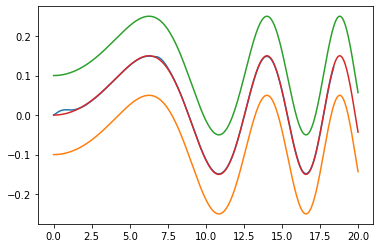

In [5]:
model = mpc_model()
mpc = controller(model,x_ref,y_ref)
simulator = mpc_simulator(model,x_ref,y_ref)
estimator = do_mpc.estimator.StateFeedback(model)

# x0=np.array([[0],[0],[0.001],[(np.pi/4)*(0.03)],[0],[0],[0],[0]])
simulator.x0['xc'] = 0
simulator.x0['yc'] = 0
simulator.x0['v'] = 3
simulator.x0['theta'] = (np.pi/4)*(0.035)
simulator.x0['phi'] = 0
simulator.x0['delta'] = 0
simulator.x0['a_s'] = 0
simulator.x0['w_s'] = 0

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

state = []
x = []
y = []
for k in range(N_ref):
    print('\n\n################################################    ' + str(k) + '    #########################################\n\n')
    state.append(x0)
    x.append(x0[0])
    y.append(x0[1])
    u0 = mpc.make_step(x0) #From Mechatronix CAN module
    y_next = simulator.make_step(u0) #From Localization
    x0 = estimator.make_step(y_next)
    
plt.plot(x,y)
plt.plot(x_ref,y_ref-1e-1)
plt.plot(x_ref,y_ref+1e-1)
plt.plot(x_ref,y_ref)

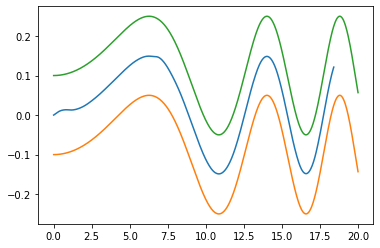

In [11]:
plt.plot(x,y)
plt.plot(x_ref,y_ref-1e-1)
plt.plot(x_ref,y_ref+1e-1)

simulator.x0['xc'] = 0      
simulator.x0['yc'] = 0                  
simulator.x0['v'] = 0.001                       
simulator.x0['theta'] = (np.pi/4)*(0.03)                       
simulator.x0['phi'] = 0                     
simulator.x0['delta'] = 0               
simulator.x0['a_s'] = 0                     
simulator.x0['w_s'] = 0                 


In [7]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
mpc_graphics.plot_predictions()
plt.show()

In [8]:
fig = plt.figure(figsize=(16,9))

ax2 = plt.subplot2grid((4, 2), (0, 0))
ax3 = plt.subplot2grid((4, 2), (1, 0))
ax4 = plt.subplot2grid((4, 2), (2, 0))
ax5 = plt.subplot2grid((4, 2), (3, 0))

ax2.set_ylabel('$$ [J]')
ax3.set_ylabel('$E_{pot}$ [J]')
ax4.set_ylabel('Angle  [rad]')
ax5.set_ylabel('Input force [N]')

# Axis on the right.
for ax in [ax2, ax3, ax4, ax5]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax5:
        ax.xaxis.set_ticklabels([])

ax5.set_xlabel('time [s]')

mpc_graphics.add_line(var_type='_aux', var_name='E_kin', axis=ax2)
mpc_graphics.add_line(var_type='_aux', var_name='E_pot', axis=ax3)
mpc_graphics.add_line(var_type='_x', var_name='theta', axis=ax4)
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax5)

ax1.axhline(0,color='black')

bar1 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar2 = ax1.plot([],[], '-o', linewidth=5, markersize=10)

ax1.set_xlim(-1.8,1.8)
ax1.set_ylim(-1.2,1.2)
ax1.set_axis_off()

fig.align_ylabels()
fig.tight_layout()

Exception: Error occured in struct context with powerIndex ('E_kin',), at canonicalIndex ()

ValueError: 
$$ [J]
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 1152x648 with 4 Axes>

In [ ]:
for i in state:
    print(i[2])

[3.]
[3.00817154]
[3.03196461]
[3.07164326]
[3.1007953]
[3.12768876]
[3.17255798]
[3.23177259]
[3.29691306]
[3.36060837]
[3.39301989]
[3.38726879]
[3.36536634]
[3.34557392]
[3.33550753]
[3.33399981]
[3.33528205]
[3.33573499]
[3.33838233]
[3.34747032]
[3.36584311]
[3.39336868]
[3.42653459]
[3.45964619]
[3.48683419]
[3.50380704]
[3.50874826]
[3.50231449]
[3.48699754]
[3.46621195]
[3.44342245]
[3.42151965]
[3.40239595]
[3.38668375]
[3.37423399]
[3.3646562]
[3.35751075]
[3.35238699]
[3.34896082]
[3.34694191]
[3.34602787]
[3.3459138]
[3.34631786]
[3.34699999]
[3.34776317]
[3.34844994]
[3.34893812]
[3.34914423]
[3.34902336]
[3.34856545]
[3.34779356]
[3.34675923]
[3.34553553]
[3.34420832]
[3.34286682]
[3.34159477]
[3.34046297]
[3.33952392]
[3.33880903]
[3.33832822]
[3.33807176]
[3.33801374]
[3.33811658]
[3.33833663]
[3.33862839]
[3.33894876]
[3.33926144]
[3.33953917]
[3.33976417]
[3.33992775]
[3.34002921]
[3.34007424]
[3.34007318]
[3.34003915]
[3.33998641]
[3.33992857]
[3.33987811]
[3.3398453